# ==================================================================================================

# 1: Data Loading

In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Cấu hình GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU có sẵn: {physical_devices}")
    try:
        # Bật memory growth cho tất cả GPU
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except Exception as e:
        print(f"Không thể bật memory growth: {str(e)}")
else:
    print("Không có GPU, chạy trên CPU.")

# Giới hạn sử dụng 1 GPU nếu cần (tránh xung đột trên Kaggle)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

RAW_IMAGES_DIR = "/kaggle/input/faceandfacemask/Data/raw_images"  # Cập nhật đường dẫn cho Kaggle
MASKED_IMAGES_DIR = "/kaggle/input/faceandfacemask/Data/raw_images_masked"
IMG_SIZE = (256, 256)
OUTPUT_DIR = "/kaggle/working/"

def is_valid_image(img):
    """Kiểm tra ảnh có hợp lệ không."""
    if img is None:
        return False
    img = img.astype(np.float32)
    return not (np.any(np.isnan(img)) or np.any(np.isinf(img)))

def load_data(raw_dir, masked_dir, img_size=(256, 256)):
    inputs, targets = [], []
    raw_files = set(os.listdir(raw_dir))
    skipped_files = []

    for filename in os.listdir(masked_dir):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            skipped_files.append(filename)
            continue

        base_name = filename.rsplit('_', 1)[0] + '.png'
        if base_name not in raw_files:
            base_name = base_name.replace('.png', '.jpg')
        if base_name not in raw_files:
            skipped_files.append(filename)
            continue

        raw_path = os.path.join(raw_dir, base_name)
        masked_path = os.path.join(masked_dir, filename)

        raw_img = cv2.imread(raw_path)
        masked_img = cv2.imread(masked_path)
        if not is_valid_image(raw_img) or not is_valid_image(masked_img):
            skipped_files.append(filename)
            continue

        raw_img = cv2.resize(raw_img, img_size) / 255.0
        masked_img = cv2.resize(masked_img, img_size) / 255.0
        raw_img = np.clip(raw_img, 0.0, 1.0).astype(np.float32)
        masked_img = np.clip(masked_img, 0.0, 1.0).astype(np.float32)

        inputs.append(masked_img)
        targets.append(raw_img)

    if skipped_files:
        print(f"Bỏ qua {len(skipped_files)} file không hợp lệ: {skipped_files[:5]}...")

    return np.array(inputs), np.array(targets)

inputs, targets = load_data(RAW_IMAGES_DIR, MASKED_IMAGES_DIR, IMG_SIZE)
print(f"Tổng ảnh hợp lệ: {len(inputs)}")
if len(inputs) == 0:
    raise ValueError("Không có ảnh hợp lệ.")

x_train, x_temp, y_train, y_temp = train_test_split(inputs, targets, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")


2025-05-27 06:42:35.722129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748328155.921194      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748328155.980734      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU có sẵn: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Bỏ qua 1172 file không hợp lệ: ['without_mask_3598_surgical_green.png', '53_surgical_blue.png', '1859_surgical_green.png', '3233_surgical_green.png', '1577_surgical_blue.png']...
Tổng ảnh hợp lệ: 4042
Train: 2829, Val: 606, Test: 607


# 2: Improved UNet Model 

In [ ]:

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def residual_block(x, filters):
    shortcut = Conv2D(filters, 1, padding='same')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = LeakyReLU()(x)
    return x

def attention_block(x, filters):
    g = Conv2D(filters, 1, padding='same')(x)
    x = Conv2D(filters, 1, padding='same')(x)
    x = Multiply()([x, g])
    return x

def build_residual_attention_unet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    c1 = residual_block(inputs, 32)
    p1 = MaxPooling2D()(c1)

    c2 = residual_block(p1, 64)
    p2 = MaxPooling2D()(c2)

    c3 = residual_block(p2, 128)
    p3 = MaxPooling2D()(c3)

    bottleneck = residual_block(p3, 256)
    bottleneck = attention_block(bottleneck, 256)

    u1 = UpSampling2D()(bottleneck)
    u1 = Concatenate()([u1, c3])
    c4 = residual_block(u1, 128)

    u2 = UpSampling2D()(c4)
    u2 = Concatenate()([u2, c2])
    c5 = residual_block(u2, 64)

    u3 = UpSampling2D()(c5)
    u3 = Concatenate()([u3, c1])
    c6 = residual_block(u3, 32)

    outputs = Conv2D(3, 1, activation='sigmoid', dtype='float32')(c6)
    return Model(inputs, outputs)

# Xây dựng và biên dịch mô hình
model = build_residual_attention_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0),
    loss='mae',
    metrics=['mae', 'mse']
)
model.summary()


I0000 00:00:1748328267.578648      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748328267.579265      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 32)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256, 256, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │          2,112 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 2,192,483 (8.36 MB)

 Trainable params: 2,189,667 (8.35 MB)

 Non-trainable params: 2,816 (11.00 KB)

# 3: Training

In [ ]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, "best_face_inpainting_model.keras"),
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

model.save(os.path.join(OUTPUT_DIR, "final_face_inpainting_model.keras"))

Epoch 1/100


I0000 00:00:1748328298.570990     101 service.cc:148] XLA service 0x7d69f40c9720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748328298.571690     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748328298.571710     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748328300.964238     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748328323.742052     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.1419 - mae: 0.1419 - mse: 0.0427
Epoch 1: val_loss improved from inf to 0.13962, saving model to /kaggle/working/best_face_inpainting_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 141s 275ms/step - loss: 0.1418 - mae: 0.1418 - mse: 0.0427 - val_loss: 0.1396 - val_mae: 0.1396 - val_mse: 0.0303 - learning_rate: 1.0000e-05
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0874 - mae: 0.0874 - mse: 0.0185
Epoch 2: val_loss improved from 0.13962 to 0.06492, saving model to /kaggle/working/best_face_inpainting_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 70s 197ms/step - loss: 0.0874 - mae: 0.0874 - mse: 0.0185 - val_loss: 0.0649 - val_mae: 0.0649 - val_mse: 0.0125 - learning_rate: 1.0000e-05
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0742 - mae: 0.0742 - mse: 0.0144
Epoch 3: val_loss improved from 0.06492 to 0.06074, saving model to /kaggle/working/best_face_inpainting_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 6

In [4]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

# 4: Evaluation and Visualization 

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step
Trung bình SSIM: 0.8209 ± 0.0631
Trung bình PSNR: 23.49 ± 3.08
Trung bình LPIPS: 0.2159 ± 0.0526
Trung bình MAE: 0.0360 ± 0.0148


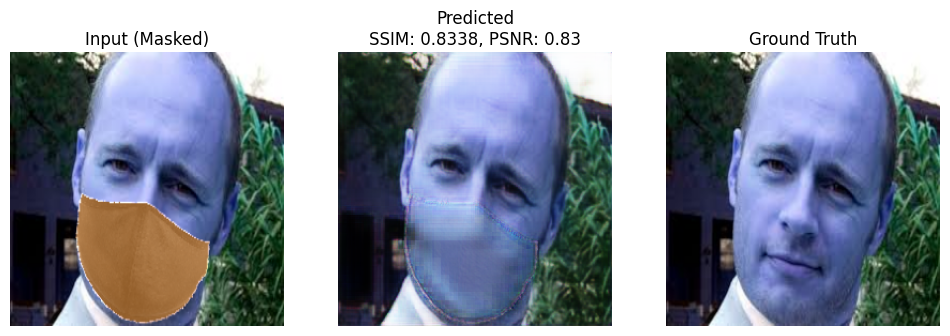

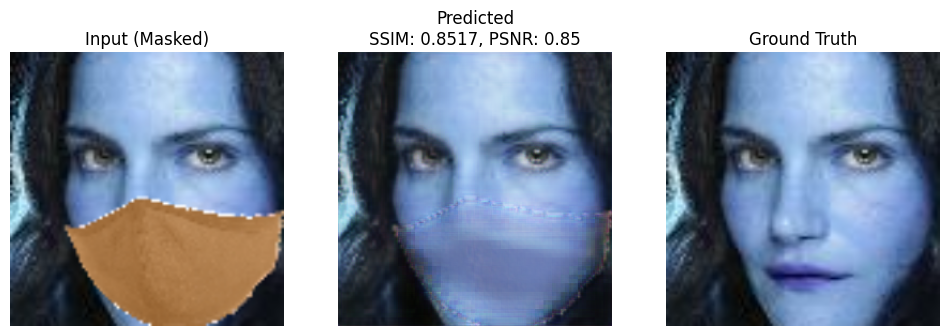

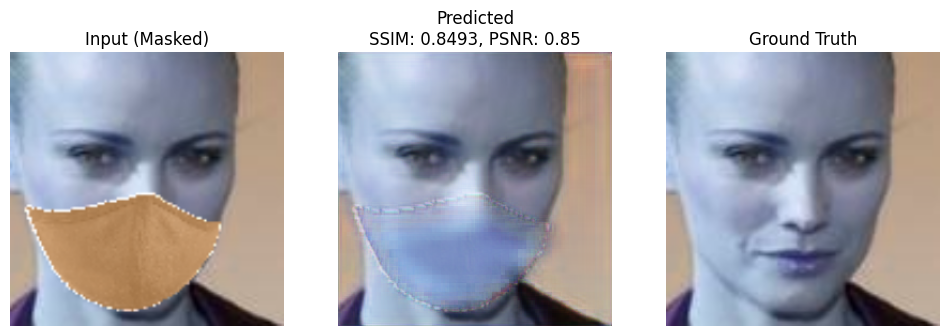

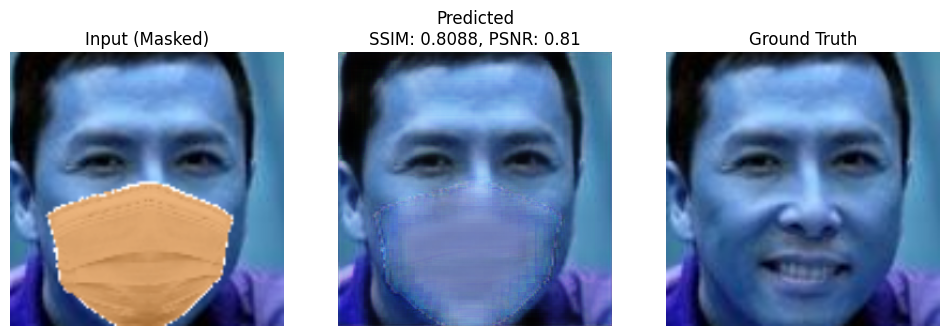

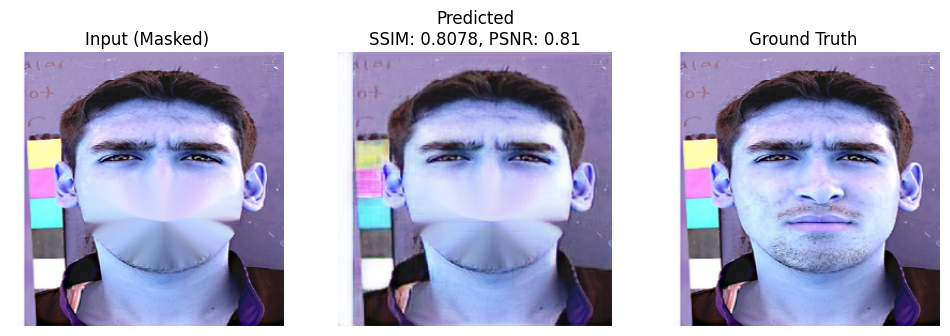

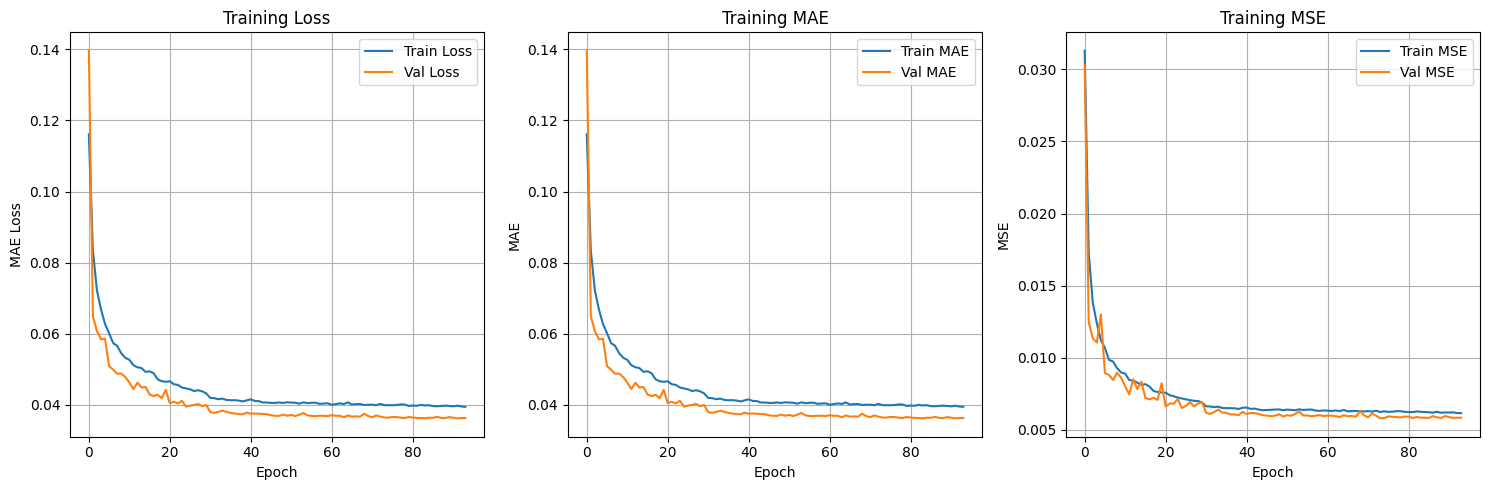

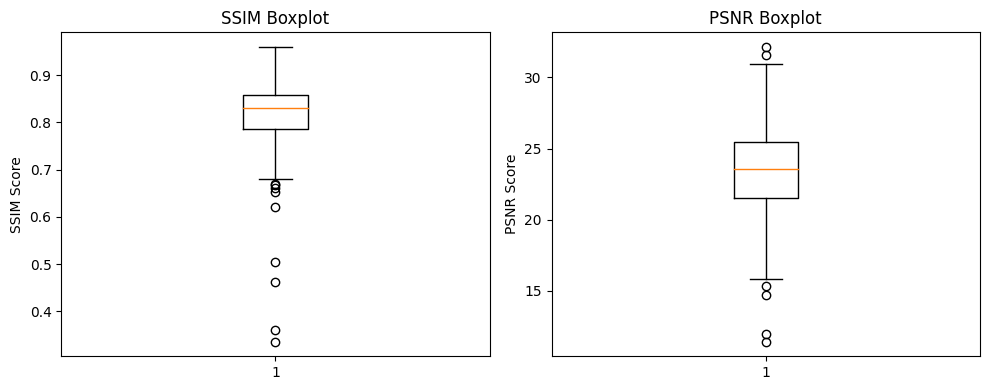

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import lpips
import torch
import matplotlib.pyplot as plt

lpips_loss = lpips.LPIPS(net='vgg').eval()  # Đặt model ở chế độ eval

# Dự đoán trên tập test
preds = model.predict(x_test, batch_size=8)

# Tính các chỉ số đánh giá
ssim_scores, psnr_scores, lpips_scores, mae_scores = [], [], [], []
for i in range(len(x_test)):
    pred = np.clip(preds[i], 0, 1)  # [256, 256, 3]
    true = y_test[i]  # [256, 256, 3]

    # Tính SSIM và PSNR
    ssim_scores.append(ssim(true, pred, channel_axis=-1, data_range=1.0))
    psnr_scores.append(psnr(true, pred, data_range=1.0))

    # Chuẩn bị cho LPIPS
    true_tensor = torch.tensor(true).permute(2, 0, 1).unsqueeze(0)  # [1, 3, 256, 256]
    pred_tensor = torch.tensor(pred).permute(2, 0, 1).unsqueeze(0)  # [1, 3, 256, 256]
    lpips_score = lpips_loss(true_tensor, pred_tensor).item()
    lpips_scores.append(lpips_score)

    # Tính MAE
    mae_scores.append(np.mean(np.abs(true - pred)))

print(f"Trung bình SSIM: {np.mean(ssim_scores):.4f} ± {np.std(ssim_scores):.4f}")
print(f"Trung bình PSNR: {np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f}")
print(f"Trung bình LPIPS: {np.mean(lpips_scores):.4f} ± {np.std(lpips_scores):.4f}")
print(f"Trung bình MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

# Trực quan hóa 5 dự đoán
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i])
    plt.title("Input (Masked)")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(preds[i])
    plt.title(f"Predicted\nSSIM: {ssim_scores[i]:.4f}, PSNR: {ssim_scores[i]:.2f}")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(y_test[i])
    plt.title("Ground Truth")
    plt.axis('off')
    plt.savefig(os.path.join(OUTPUT_DIR, f'prediction_{i}.png'))
    plt.show()

# Biểu đồ hiệu suất
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training MAE")
plt.legend()
plt.grid(True)
plt.subplot(1, 3, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_metrics.png'))
plt.show()

# Boxplot SSIM và PSNR
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(ssim_scores)
plt.ylabel('SSIM Score')
plt.title('SSIM Boxplot')
plt.subplot(1, 2, 2)
plt.boxplot(psnr_scores)
plt.ylabel('PSNR Score')
plt.title('PSNR Boxplot')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'boxplot_metrics.png'))
plt.show()